In [1]:
import pandas as pd
import numpy as np
import argparse
import random
from model import KGCN
from data_loader import DataLoader
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# prepare arguments (hyperparameters)
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default='book', help='which dataset to use')
parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
parser.add_argument('--n_epochs', type=int, default=40, help='the number of epochs')
parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=32, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.8, help='size of training dataset')

args = parser.parse_args(['--l2_weight', '1e-4'])

# build dataset and knowledge graph
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()
df_dataset

# Dataset class
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        item_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return user_id, item_id, label

# train test split
x_train, x_test, y_train, y_test = train_test_split(df_dataset, df_dataset['label'], test_size=1 - args.ratio, shuffle=False, random_state=999)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)
print('device: ', device)

inIt data          userID       itemID  rating
0        276725   034545104X     0.0
1        276726   0155061224     5.0
2        276727   0446520802     0.0
3        276729   052165615X     3.0
4        276729   0521795028     6.0
...         ...          ...     ...
1149775  276704   1563526298     9.0
1149776  276706   0679447156     0.0
1149777  276709   0515107662    10.0
1149778  276721   0590442449    10.0
1149779  276723  05162443314     8.0

[1149780 rows x 3 columns]
Construct knowledge graph ... Done
Build dataset dataframe ... Done
device:  cuda


In [4]:
# train
from sklearn.metrics import precision_score, recall_score, f1_score
loss_list = []
test_loss_list = []
auc_score_list = []
f1_score_list = []
recall_score_list = []
precision_score_list =[]

for epoch in range(args.n_epochs):
    running_loss = 0.0
    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    
    # print train loss per every epoch
    print('[Epoch {}]train_loss: '.format(epoch+1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))
        
    # evaluate per every epoch
    with torch.no_grad():
        test_loss = 0
        total_roc = 0
        total_precision =0
        total_recall =0
        total_f1 =0
        for user_ids, item_ids, labels in test_loader:
            user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
            outputs = net(user_ids, item_ids)
            # 获取输出和标签，转换为NumPy数组
            labels_cpu = labels.cpu().detach().numpy()
            outputs_cpu = outputs.cpu().detach().numpy()
            
            # 检查标签是否包含多个类别，如果只有一个类别，跳过 ROC AUC 的计算
            if len(set(labels_cpu)) > 1:  # 如果标签中包含多个类别
                total_roc += roc_auc_score(labels_cpu, outputs_cpu)
            else:
                print("Warning: Only one class present in y_true, skipping ROC AUC calculation.")
            
            test_loss += criterion(outputs, labels).item()
            # total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
            
            # 将输出值转换为0或1（阈值为0.5），用于计算Precision、Recall和F1
            preds = (outputs >= 0.5).float()

            # 计算Precision、Recall和F1
            precision = precision_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
            recall = recall_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
            f1 = f1_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
            
            total_precision += precision
            total_recall += recall
            total_f1 += f1
            
        
        print('[Epoch {}]test_loss: '.format(epoch+1), test_loss / len(test_loader))
        print('[Epoch {}]AUC: '.format(epoch+1), total_roc / len(test_loader))
        print('[Epoch {}]test_loss: '.format(epoch+1), total_f1/ len(test_loader))
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))
        f1_score_list.append(total_f1/ len(test_loader))
        recall_score_list.append(total_recall/ len(test_loader))
        precision_score_list.append(total_precision/ len(test_loader))  

[Epoch 1]train_loss:  0.6993020451174373
[Epoch 1]test_loss:  0.6860470652828098
[Epoch 1]AUC:  0.5521420510350002
[Epoch 1]test_loss:  0.5351757574488002
[Epoch 2]train_loss:  0.6695474425000116
[Epoch 2]test_loss:  0.6494067254284563
[Epoch 2]AUC:  0.6730290888142791
[Epoch 2]test_loss:  0.6155973333556427
[Epoch 3]train_loss:  0.5986534018556257
[Epoch 3]test_loss:  0.5771778513388921
[Epoch 3]AUC:  0.8136294628430994
[Epoch 3]test_loss:  0.6865515181530875
[Epoch 4]train_loss:  0.5037594390902155
[Epoch 4]test_loss:  0.5366685208312687
[Epoch 4]AUC:  0.8480838773399416
[Epoch 4]test_loss:  0.688744703892016
[Epoch 5]train_loss:  0.44294355998183216
[Epoch 5]test_loss:  0.5210209987639389
[Epoch 5]AUC:  0.8558712079955535
[Epoch 5]test_loss:  0.6909700281302416
[Epoch 6]train_loss:  0.41084304253363724
[Epoch 6]test_loss:  0.5143749759127841
[Epoch 6]AUC:  0.8579811339763249
[Epoch 6]test_loss:  0.6919014388965838
[Epoch 7]train_loss:  0.3938314276924362
[Epoch 7]test_loss:  0.51128

In [5]:
test_loss_list

[0.6860470652828098,
 0.6494067254284563,
 0.5771778513388921,
 0.5366685208312687,
 0.5210209987639389,
 0.5143749759127841,
 0.5112813306573523,
 0.5097818814543329,
 0.5090319794329685,
 0.508644974838919,
 0.5084417691597571,
 0.5083341894055603,
 0.5082766778627701,
 0.5082457752088995,
 0.5082291841754795,
 0.5082203336292394,
 0.508215682484256,
 0.5082133028834377,
 0.5082121458593872,
 0.5082116332718339,
 0.5082114563166723,
 0.5082114425617543,
 0.5082114975194674,
 0.50821158110228,
 0.5082116692700653,
 0.5082117468428463,
 0.5082118124575228,
 0.5082118653086267,
 0.5082119098572127,
 0.5082119456695667,
 0.5082119707010392,
 0.5082119916432117,
 0.5082120108505297,
 0.5082120231184295,
 0.5082120354482885,
 0.5082120422637884,
 0.5082120486455747,
 0.5082120521152838,
 0.5082120565763383,
 0.5082120589927428]

In [6]:
auc_score_list

[0.5521420510350002,
 0.6730290888142791,
 0.8136294628430994,
 0.8480838773399416,
 0.8558712079955535,
 0.8579811339763249,
 0.8578613947850742,
 0.8571262261890928,
 0.8569209322594984,
 0.8573208097594168,
 0.8570645672196693,
 0.8568049689813856,
 0.8566861083386279,
 0.8568381902235014,
 0.8566009246373432,
 0.8564917723682645,
 0.856448809453189,
 0.856448809453189,
 0.856506559510939,
 0.8565273654140978,
 0.8565179154046478,
 0.8565134154001479,
 0.856517915404648,
 0.8565224154091479,
 0.8565224154091479,
 0.856517915404648,
 0.8565224154091479,
 0.8565179154046478,
 0.8564671983498823,
 0.8564716983543822,
 0.8564370483197323,
 0.8564370483197323,
 0.8564452012690618,
 0.8564452012690618,
 0.8564452012690618,
 0.8564452012690618,
 0.8564452012690618,
 0.8564452012690618,
 0.8564452012690618,
 0.8564452012690618]

In [7]:
f1_score_list

[0.5351757574488002,
 0.6155973333556427,
 0.6865515181530875,
 0.688744703892016,
 0.6909700281302416,
 0.6919014388965838,
 0.6919354355798311,
 0.6912479224792506,
 0.6911171360363341,
 0.6913874248422902,
 0.6913141957219667,
 0.6910225663941951,
 0.6909537075018068,
 0.6910872085619489,
 0.6909036823925785,
 0.690850646625257,
 0.6908355134664538,
 0.6908355134664538,
 0.6909114135423537,
 0.6909114135423537,
 0.6909114135423537,
 0.6909114135423537,
 0.6909114135423537,
 0.6909114135423537,
 0.6909114135423537,
 0.6909114135423537,
 0.6909114135423537,
 0.6909114135423537,
 0.6908404465745066,
 0.6908404465745066,
 0.6907855046590996,
 0.6907855046590996,
 0.6907855046590996,
 0.6907855046590996,
 0.6907855046590996,
 0.6907855046590996,
 0.6907855046590996,
 0.6907855046590996,
 0.6907855046590996,
 0.6907855046590996]

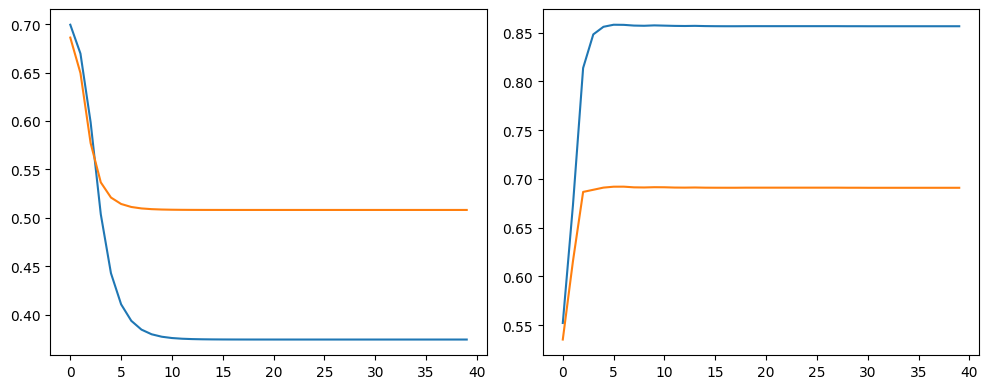

In [8]:
# plot losses / scores
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
ax1.plot(loss_list)
ax1.plot(test_loss_list)
ax2.plot(auc_score_list)
ax2.plot(f1_score_list)

plt.tight_layout()